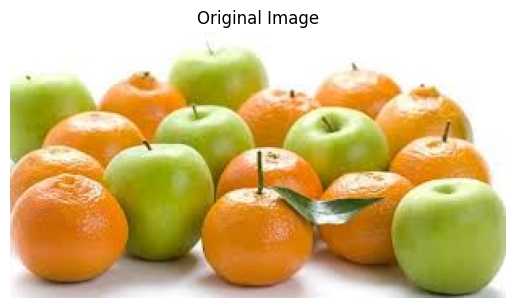

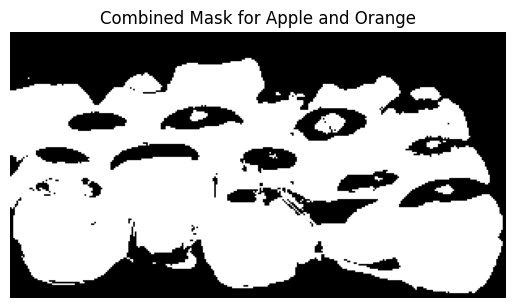

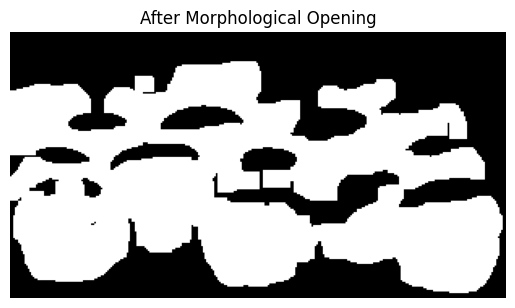

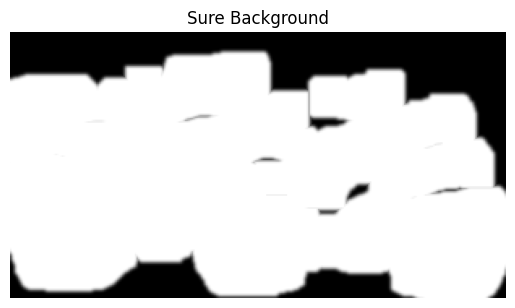

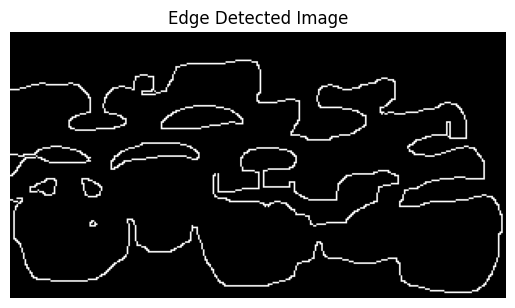

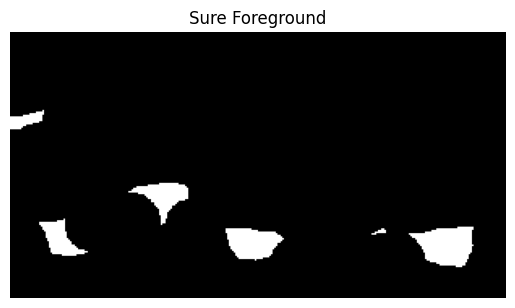

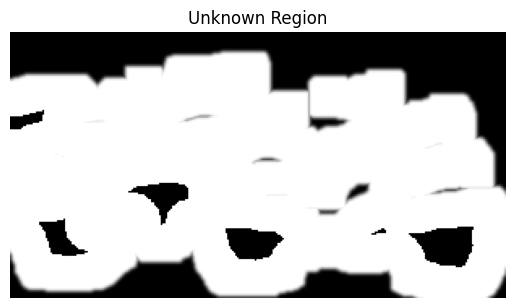

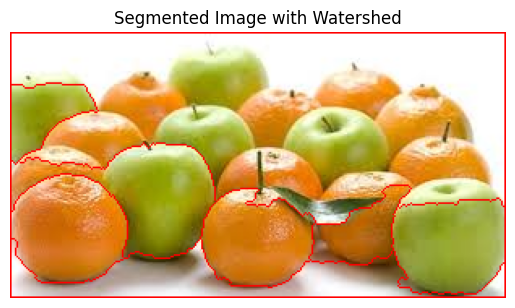

Object 1: Area = 1364.5, Aspect Ratio = 1.0816326530612246, Centroid = (19, 49), Label = Orange
Object 2: Area = 4012.0, Aspect Ratio = 1.8, Centroid = (83, 99), Label = Orange
Object 3: Area = 3632.0, Aspect Ratio = 1.0757575757575757, Centroid = (35, 121), Label = Apple
Object 4: Area = 2979.0, Aspect Ratio = 1.1666666666666667, Centroid = (151, 127), Label = Orange
Object 5: Area = 1435.5, Aspect Ratio = 1.2916666666666667, Centroid = (215, 123), Label = Orange
Object 6: Area = 3351.5, Aspect Ratio = 1.1896551724137931, Centroid = (270, 131), Label = Apple


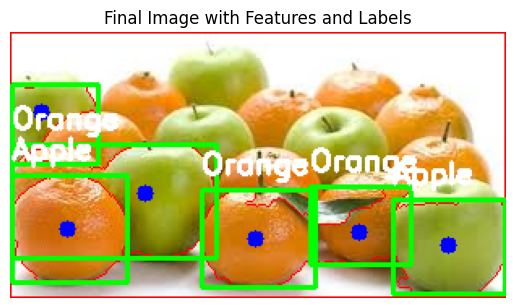

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(r"/content/images.jpeg")
# Convert the image to RGB (from BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define color ranges for apple and orange in HSV
apple_lower = np.array([24, 100, 100])
apple_upper = np.array([250, 255, 255])
orange_lower = np.array([11, 100, 100])
orange_upper = np.array([25, 255, 255])

# Create masks for apple and orange
mask_apple = cv2.inRange(hsv, apple_lower, apple_upper)
mask_orange = cv2.inRange(hsv, orange_lower, orange_upper)

# Combine masks
combined_mask = cv2.bitwise_or(mask_apple, mask_orange)

# Display the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Mask for Apple and Orange')
plt.axis('off')
plt.show()

# Apply morphological operations
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Display the opened image
plt.imshow(opening, cmap='gray')
plt.title('After Morphological Opening')
plt.axis('off')
plt.show()

# Apply Gaussian blur for better segmentation
blurred = cv2.GaussianBlur(opening, (5, 5), 0)

# Sure background area (dilated)
sure_bg = cv2.dilate(blurred, kernel, iterations=3)

# Display the sure background image
plt.imshow(sure_bg, cmap='gray')
plt.title('Sure Background')
plt.axis('off')
plt.show()

# Apply Canny edge detection
edges = cv2.Canny(blurred, 100, 200)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title('Edge Detected Image')
plt.axis('off')
plt.show()

# Finding the sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

# Convert to uint8
sure_fg = np.uint8(sure_fg)

# Display the sure foreground image
plt.imshow(sure_fg, cmap='gray')
plt.title('Sure Foreground')
plt.axis('off')
plt.show()

# Finding unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Display the unknown region
plt.imshow(unknown, cmap='gray')
plt.title('Unknown Region')
plt.axis('off')
plt.show()

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels to ensure background is not 0, but 1
markers = markers + 1

# Mark the unknown regions with zero
markers[unknown == 255] = 0

# Apply watershed algorithm
markers = cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]

# Display the segmented image
image_rgb_final = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_final)
plt.title('Segmented Image with Watershed')
plt.axis('off')
plt.show()

# Extract features for each labeled region and classify as 'apple' or 'orange'
for marker in range(2, np.max(markers) + 1):
    mask = np.uint8(markers == marker)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        # Compute area and centroid
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])

        # Bounding box and aspect ratio (additional feature)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h

        # Simple classification based on area and aspect ratio
        if area > 3350 and aspect_ratio < 1.2:
            label = 'Apple'
        else:
            label = 'Orange'

        # Draw the bounding box, centroid, and label on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.circle(image, (centroid_x, centroid_y), 5, (255, 0, 0), -1)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        print(f'Object {marker-1}: Area = {area}, Aspect Ratio = {aspect_ratio}, Centroid = ({centroid_x}, {centroid_y}), Label = {label}')

# Display the final image with features and labels
image_rgb_final = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_final)
plt.title('Final Image with Features and Labels')
plt.axis('off')
plt.show()


Reference Features:
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 2.0, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (88, 142, 2, 1)}
{'area': 65.0, 'centroid': (108, 141), 'aspect_ratio': 1.5833333333333333, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (96, 134, 19, 12)}
{'area': 1.5, 'centroid': (162, 76), 'aspect_ratio': 1.6666666666666667, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (160, 75, 5, 3)}
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 1.0, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (160, 74, 1, 1)}
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 2.0, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (267, 67, 2, 1)}
{'area': 20.5, 'centroid': (260, 68), 'aspect_ratio': 1.8, 'average_color': array([15.11963973, 48.37490037, 75.60349912]), 'bounding_box': (257, 67, 9, 5)}
{'area': 1.5, 'cen

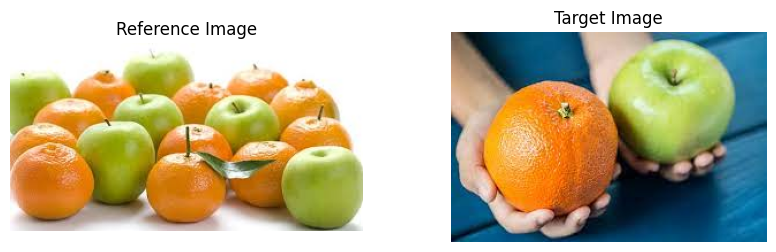

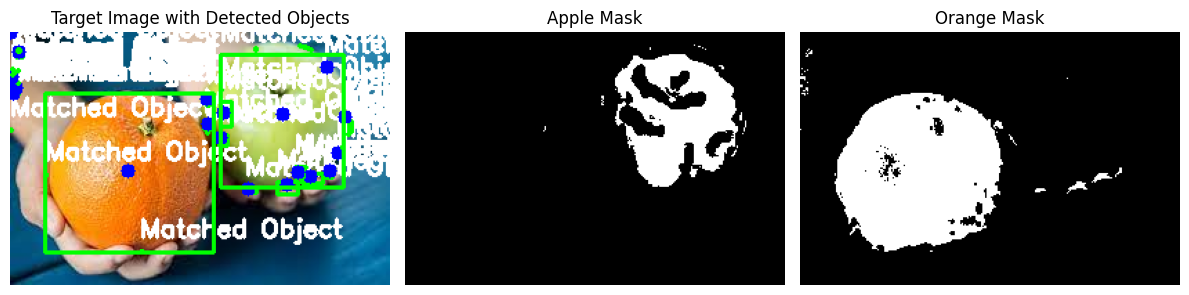

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to extract features from an object
def extract_features(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []

    for cnt in contours:
        # Compute area, centroid, and average color intensity
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        centroid_y = int(M['m01'] / M['m00']) if M['m00'] != 0 else 0

        # Bounding box and aspect ratio (additional feature)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h if h != 0 else 0

        # Calculate average color intensity within the segmented region
        mask_rgb = cv2.bitwise_and(image, image, mask=mask)
        average_color = np.mean(mask_rgb, axis=(0, 1))

        features.append({
            'area': area,
            'centroid': (centroid_x, centroid_y),
            'aspect_ratio': aspect_ratio,
            'average_color': average_color,
            'bounding_box': (x, y, w, h)  # Store bounding box for drawing
        })

    return features

# Load the reference object (replace with your reference object image path)
reference_image = cv2.imread(r"/content/images.jpeg")
reference_hsv = cv2.cvtColor(reference_image, cv2.COLOR_BGR2HSV)

# Define the range for the reference object in HSV
reference_lower = np.array([11, 100, 100])
reference_upper = np.array([25, 255, 255])
reference_mask = cv2.inRange(reference_hsv, reference_lower, reference_upper)

# Extract features from the reference object
reference_features = extract_features(reference_image, reference_mask)

# Display reference features for debugging
print("Reference Features:")
for feat in reference_features:
    print(feat)

# Load the target image
target_image = cv2.imread(r"/content/imagest.jpeg")
target_hsv = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10, 6))

# Plot reference image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title('Reference Image')
plt.axis('off')

# Plot target image
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.title('Target Image')
plt.axis('off')

# Define your masks for apples and oranges using HSV color ranges

mask_apple = cv2.inRange(target_hsv, np.array([35, 100, 100]), np.array([85, 255, 255]))

# Mask for oranges (assuming orange color)
mask_orange = cv2.inRange(target_hsv, np.array([10, 100, 100]), np.array([25, 255, 255]))  # Orange range

# Combine the masks for apples and oranges
target_combined_mask = cv2.bitwise_or(mask_apple, mask_orange)

# Extract features from the target image
target_features = extract_features(target_image, target_combined_mask)

# Set a threshold value for matching
threshold_value = 2000.0  # Define a suitable threshold for matching

# Compare features for object detection
for i, target_feat in enumerate(target_features):
    best_match = None
    best_distance = float('inf')

    for ref_feat in reference_features:
        # Calculate similarity measures using Euclidean distance for feature comparison
        distance = np.sqrt(
            (target_feat['area'] - ref_feat['area']) ** 2 +
            (target_feat['centroid'][0] - ref_feat['centroid'][0]) ** 2 +
            (target_feat['centroid'][1] - ref_feat['centroid'][1]) ** 2 +
            (target_feat['aspect_ratio'] - ref_feat['aspect_ratio']) ** 2 +
            np.sum((target_feat['average_color'] - ref_feat['average_color']) ** 2)
        )

        if distance < best_distance:
            best_distance = distance
            best_match = ref_feat

    # Locate and identify the object
    if best_distance < threshold_value:
        label = 'Matched Object'
    else:
        label = 'No Match'

    # Draw bounding box, centroid, and label on the target image
    x, y, w, h = target_feat['bounding_box']  # Use the bounding box stored during feature extraction
    cv2.rectangle(target_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.circle(target_image, target_feat['centroid'], 5, (255, 0, 0), -1)
    cv2.putText(target_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

# Display the final image with features and labels
target_image_rgb_final = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))

# Plot target image
plt.subplot(1, 3, 1)
plt.imshow(target_image_rgb_final)
plt.title('Target Image with Detected Objects')
plt.axis('off')

# Plot masks
plt.subplot(1, 3, 2)
plt.imshow(mask_apple, cmap='gray')
plt.title('Apple Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask_orange, cmap='gray')
plt.title('Orange Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Create a list to store the labeled data
labeled_data = []

# Compare features for object detection and label them
for i, target_feat in enumerate(target_features):
    best_match = None
    best_distance = float('inf')
    label = 'No Match'  # Default label for no match

    for ref_feat in reference_features:
        # Calculate Euclidean distance for feature comparison
        distance = np.sqrt(
            (target_feat['area'] - ref_feat['area']) ** 2 +
            (target_feat['centroid'][0] - ref_feat['centroid'][0]) ** 2 +
            (target_feat['centroid'][1] - ref_feat['centroid'][1]) ** 2 +
            (target_feat['aspect_ratio'] - ref_feat['aspect_ratio']) ** 2 +
            np.sum((target_feat['average_color'] - ref_feat['average_color']) ** 2)
        )

        if distance < best_distance:
            best_distance = distance
            best_match = ref_feat

    # Set label based on threshold and best match
    if best_distance < threshold_value:
        label = 'Matched Object'  # You can modify this to a specific object name

    # Store features and label for the dataset
    labeled_data.append({
        'Object_ID': i,
        'Area': target_feat['area'],
        'Centroid_X': target_feat['centroid'][0],
        'Centroid_Y': target_feat['centroid'][1],
        'Aspect_Ratio': target_feat['aspect_ratio'],
        'Average_Color': target_feat['average_color'].tolist(),  # Convert numpy array to list for storage
        'Label': label
    })

# Convert labeled data to DataFrame for easy manipulation
labeled_df = pd.DataFrame(labeled_data)

# Save the labeled dataset to a CSV file
labeled_df.to_csv('labeled_dataset.csv', index=False)

print("Labeled dataset created and saved as 'labeled_dataset.csv'")


Labeled dataset created and saved as 'labeled_dataset.csv'
